In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from scipy.interpolate import interp1d
from numpy import array
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("WISDM.csv")

In [3]:
df.shape

(1098203, 7)

In [4]:
df.head()

,Unnamed: 0,user-id,activity,timestamp,X,Y,Z
0,0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
Walking = df[df['activity']=='Walking'].head(24000).copy()

Jogging = df[df['activity']=='Jogging'].head(24000).copy()

Upstairs = df[df['activity']=='Upstairs'].head(24000).copy()

Downstairs = df[df['activity']=='Downstairs'].head(24000).copy()

Sitting = df[df['activity']=='Sitting'].head(48000).copy()

Standing = df[df['activity']=='Standing'].head(48000).copy()

In [6]:
balanced_data = pd.DataFrame()

balanced_data = pd.concat([balanced_data, Jogging, Sitting])

balanced_data.shape

(72000, 7)

In [7]:
balanced_data['activity'].value_counts()

activity
Sitting    48000
Jogging    24000
Name: count, dtype: int64

In [8]:
sitting_samples = balanced_data[balanced_data['activity'] == 'Sitting'].head(4499)
jogging_samples = balanced_data[balanced_data['activity'] == 'Jogging'].head(4500)

In [9]:
selected_data = pd.concat([sitting_samples, jogging_samples])
selected_data['activity'].value_counts()

activity
Jogging    4500
Sitting    4499
Name: count, dtype: int64

In [10]:
unwanted_columns = ['Unnamed: 0', 'user-id', 'timestamp']

selected_data = selected_data.drop(columns = unwanted_columns)

In [11]:
le=LabelEncoder()

selected_data['activity']=le.fit_transform(selected_data['activity'])

In [12]:
X_train, X_test = train_test_split(selected_data, test_size=0.25, random_state=42)

In [13]:
selected_data.shape

(8999, 4)

In [14]:
sitting_train = X_train[X_train['activity'] == 0]

In [15]:
#X_train.shape
sitting_train.shape

(3350, 4)

In [16]:
y_train_sitting = sitting_train['activity']

In [17]:
X_train_sitting = sitting_train.drop(['activity'], axis=1)

In [18]:
X_test = X_test[X_test['activity'] != 'Sitting']

In [19]:
y_test = X_test['activity']

In [20]:
X_test = X_test.drop(['activity'], axis=1)

In [21]:
X_train_sitting = X_train_sitting.values
X_test = X_test.values

In [22]:
X_test.shape

(2250, 3)

In [23]:
noise_factor = 0.50

X_train_AE_noisy = X_train_sitting.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_sitting.shape)

In [24]:
input_dim = X_train_AE_noisy.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(3, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [25]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# 데이터를 훈련 및 검증 세트로 분할
from sklearn.model_selection import train_test_split
X_train_AE_noisy, X_val = train_test_split(X_train_AE_noisy, test_size=0.2, train_size=0.8)  # 예를 들어, 80%는 훈련, 20%는 검증

history = autoencoder.fit(X_train_AE_noisy, X_train_AE_noisy,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),  # 검증 데이터를 사용
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10


84/84 [==============================] - 4s 15ms/step - loss: 66.2416 - accuracy: 0.6709 - val_loss: 47.3471 - val_accuracy: 0.5898
Epoch 2/10
 5/84 [>.............................] - ETA: 1s - loss: 63.2718 - accuracy: 0.6687

c:\Users\khw\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 1s 9ms/step - loss: 65.0909 - accuracy: 0.6743 - val_loss: 46.4541 - val_accuracy: 0.5898
Epoch 3/10
84/84 [==============================] - 1s 9ms/step - loss: 63.9429 - accuracy: 0.6743 - val_loss: 45.5839 - val_accuracy: 0.5898
Epoch 4/10
84/84 [==============================] - 1s 9ms/step - loss: 62.8281 - accuracy: 0.6743 - val_loss: 44.8163 - val_accuracy: 0.5898
Epoch 5/10
84/84 [==============================] - 1s 9ms/step - loss: 61.7259 - accuracy: 0.6743 - val_loss: 43.9231 - val_accuracy: 0.5898
Epoch 6/10
84/84 [==============================] - 1s 11ms/step - loss: 60.0030 - accuracy: 0.6743 - val_loss: 43.0120 - val_accuracy: 0.5898
Epoch 7/10
84/84 [==============================] - 1s 10ms/step - loss: 58.8183 - accuracy: 0.6743 - val_loss: 42.3809 - val_accuracy: 0.5898
Epoch 8/10
84/84 [==============================] - 1s 11ms/step - loss: 57.8477 - accuracy: 0.6743 - val_loss: 41.7826 - val_accuracy: 0.5898
Epoch 9/10
84/

In [26]:
LABELS = ["Normal", "AbNormal"]

In [27]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,40.687792,0.488889
std,33.822730,0.499988
min,0.095046,0.000000
25%,19.328177,0.000000
50%,31.247096,0.000000
75%,43.821770,1.000000
max,195.153344,1.000000


In [28]:
threshold = 2.9

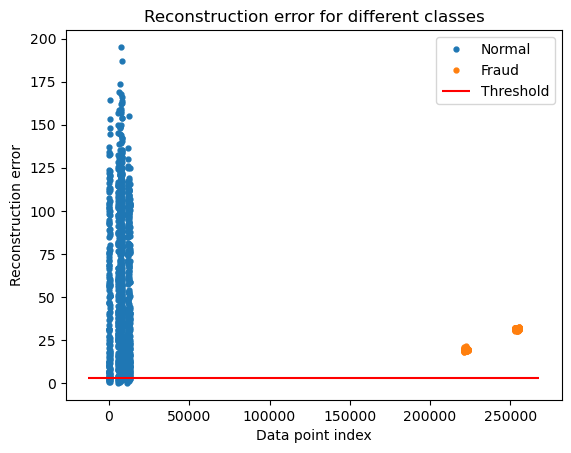

In [29]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

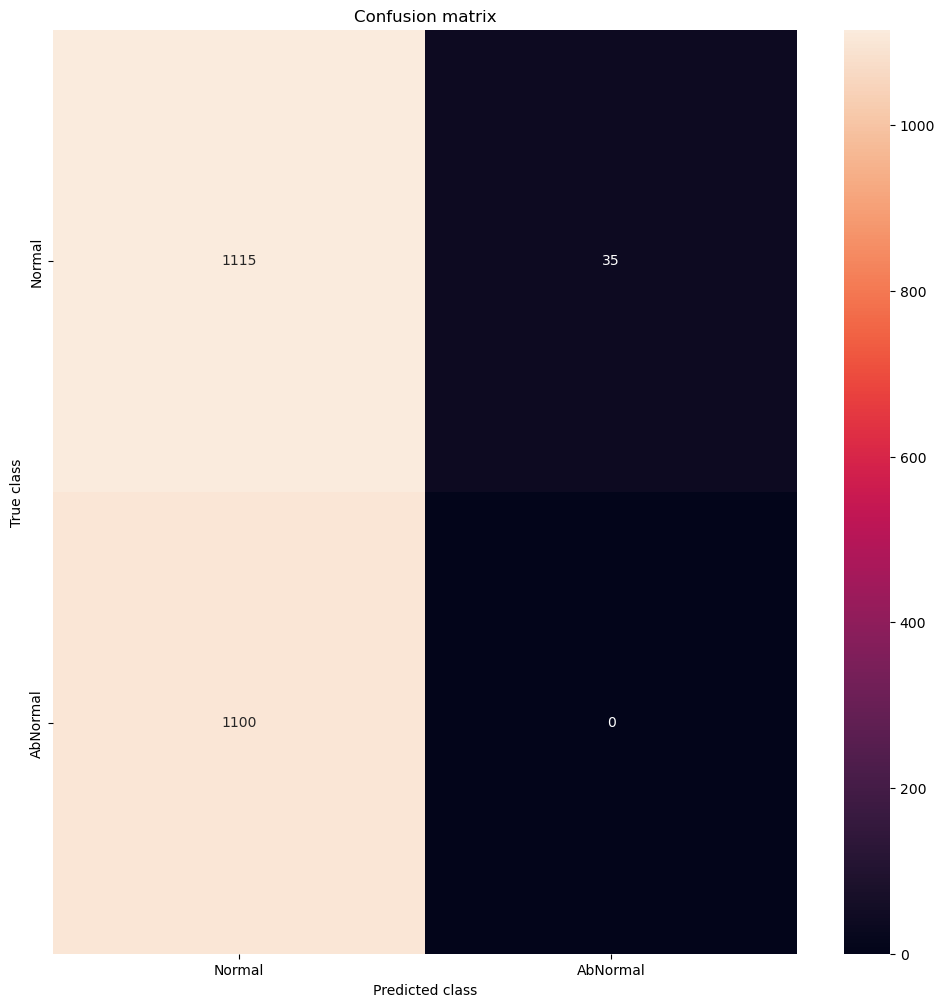

In [30]:
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [31]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.4955555555555556
Precision : 0.0
Recall : 0.0
F1 : 0.0
